# Unit17｜遷移學習 + 工業缺陷檢測（NEU Surface Defect Database）

**Part 4 - 深度學習進階應用**

## 📚 本單元學習目標

1. **理解遷移學習**：從 ImageNet 預訓練模型遷移到工業缺陷檢測
2. **兩階段訓練策略**：凍結 → 微調（Feature Extraction + Fine-tuning）
3. **工業AI實務技巧**：
   - 資料載入與預處理（`ImageDataGenerator`）
   - 學習率調度（Learning Rate Scheduling）
   - 模型評估與校正（Calibration）
   - 決策邏輯設計（Pass/Review/Fail）
4. **對比學習**：Baseline（sklearn）vs. 遷移學習（MobileNetV2）

---

## 🎯 NEU Surface Defect Database 簡介

- **來源**：東北大學（Northeastern University, China）
- **內容**：6種鋼材表面缺陷，每類300張灰階影像
- **影像尺寸**：200 × 200 pixels
- **分割**：訓練集 1440張（240×6）、驗證集 360張（60×6）

**缺陷類型（中英對照）**：
1. **crazing（龜裂）**：表面細小裂紋網，嚴重影響結構強度
2. **inclusion（夾雜）**：內部雜質暴露於表面，點狀瑕疵
3. **patches（斑塊）**：不規則的大面積暗色區域
4. **pitted_surface（麻點）**：小而密集的表面凹陷
5. **rolled-in_scale（氧化皮）**：高溫氧化產生的鱗片狀缺陷
6. **scratches（劃痕）**：線性機械損傷

---

## 📖 教學流程

### Part 1：Baseline（承接 Unit16 結果）
- 延續 Unit16 的 Random Forest 和 MLP baseline 結果
- 理解工業品檢的決策邏輯（Pass/Review/Fail）
- 學習模型校正（Calibration）與可靠性評估

### Part 2：遷移學習（深度學習）
- 使用 MobileNetV2 + ImageNet 預訓練權重
- 兩階段訓練：凍結特徵提取器 → 微調
- 學習率調度、Early Stopping、模型檢查點

### Part 3：模型評估與對比
- 混淆矩陣分析
- 預測結果可視化
- Baseline vs. Transfer Learning 性能對比

---

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib

# 路徑設定：使用 Part_4 本地 data 資料夾
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = NOTEBOOK_DIR / 'data'
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)
os.chdir(OUTPUT_DIR)

os.makedirs('P4_Unit17_Results', exist_ok=True)
print('Data directory:', DATA_DIR.resolve())
print('Output directory:', (Path.cwd() / 'P4_Unit17_Results').resolve())

# 設定 Matplotlib 中文字體（避免顯示警告）
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False
print('\n✓ Matplotlib 中文字體已設定')

Data directory: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data
Output directory: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit17_Results

✓ Matplotlib 中文字體已設定


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

def load_image_folder(root: Path, size=(64, 64), limit_per_class=None):
    """載入影像並扁平化為向量（用於傳統 ML）"""
    X, y, paths = [], [], []
    class_dirs = [p for p in sorted(root.iterdir()) if p.is_dir()]
    classes = [p.name for p in class_dirs]
    for ci, cdir in enumerate(class_dirs):
        files = sorted([p for p in cdir.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp'}])
        if limit_per_class is not None:
            files = files[:limit_per_class]
        for fp in files:
            img = Image.open(fp).convert('L').resize(size)
            arr = np.asarray(img, dtype=np.float32).reshape(-1)  # 保持 [0, 255] 範圍
            X.append(arr)
            y.append(ci)
            paths.append(str(fp))
    return np.asarray(X), np.asarray(y), np.asarray(paths), classes

train_root = DATA_DIR / 'NEU-DET' / 'train' / 'images'
val_root = DATA_DIR / 'NEU-DET' / 'validation' / 'images'
assert train_root.exists(), f'Missing: {train_root}'
assert val_root.exists(), f'Missing: {val_root}'

print('正在載入影像（64×64，用於 Baseline）...')
X_tr_raw, y_tr, p_tr, classes = load_image_folder(train_root, size=(64, 64), limit_per_class=250)
X_va_raw, y_va, p_va, _ = load_image_folder(val_root, size=(64, 64), limit_per_class=120)

print('classes:', classes)

print('train:', X_tr_raw.shape, 'val:', X_va_raw.shape)

正在載入影像（64×64，用於 Baseline）...
classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
train: (1440, 4096) val: (360, 4096)


Saved: P4_Unit17_Results/00_defect_samples.png


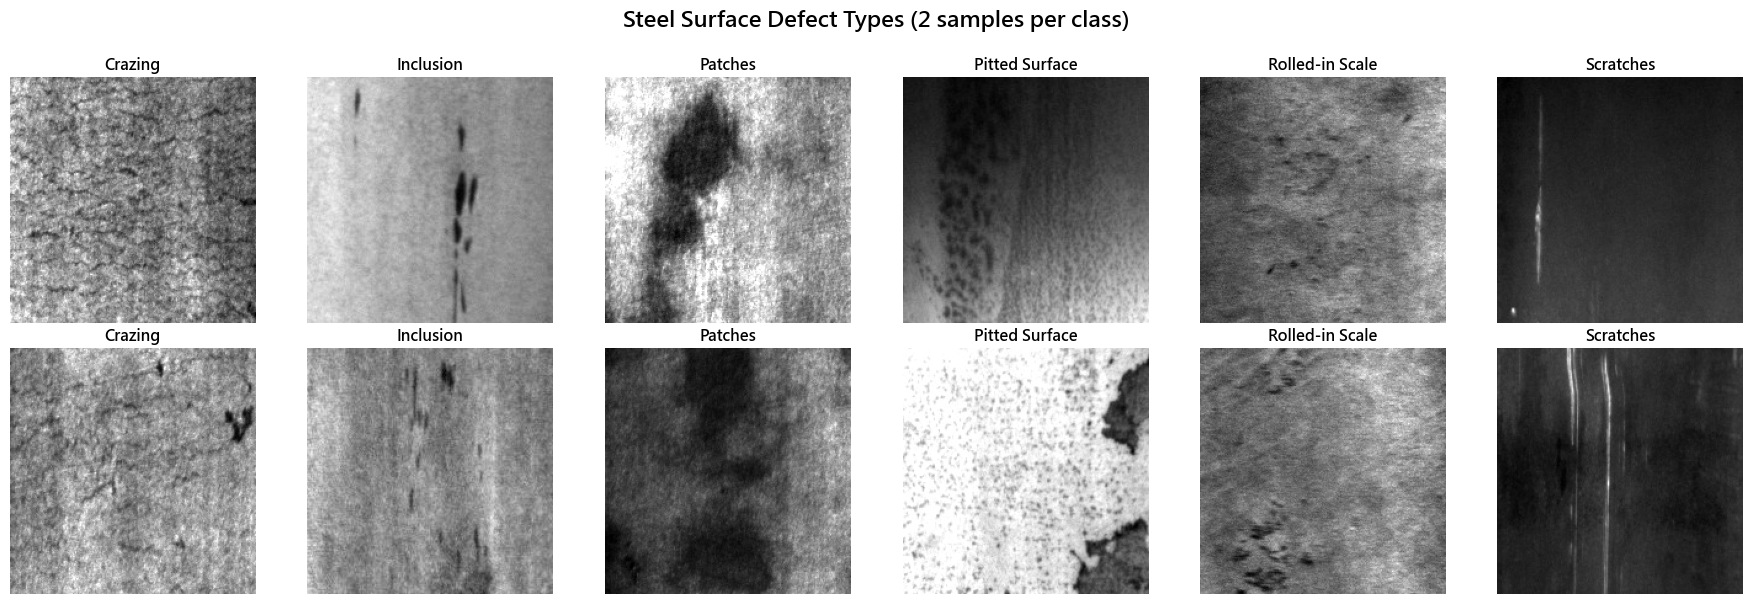


【缺陷特徵觀察】
1. 龜裂 (crazing)    ：細密的裂紋網，需高解析度辨識
2. 夾雜 (inclusion)  ：不規則黑色斑點，大小不一
3. 斑塊 (patches)    ：大面積的色差區域
4. 麻點 (pitted_surface)：小而密集的凹陷點
5. 氧化皮 (rolled-in_scale)：鱗片狀的紋理
6. 劃痕 (scratches)  ：線性的明顯痕跡


In [3]:
# 視覺化每種缺陷的範例影像
import glob

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.ravel()

class_names_display = ['Crazing', 'Inclusion', 'Patches', 
                       'Pitted Surface', 'Rolled-in Scale', 'Scratches']

for i, (class_name, display_name) in enumerate(zip(classes, class_names_display)):
    class_dir = train_root / class_name
    img_files = sorted(list(class_dir.glob('*.jpg')))
    
    # 選擇第1張和第121張影像（確保不同樣本）
    sample_indices = [0, 120] if len(img_files) >= 121 else [0, min(1, len(img_files)-1)]
    
    for j, idx in enumerate(sample_indices):
        if idx < len(img_files):
            img = Image.open(img_files[idx]).convert('L')
            axes[i + j * 6].imshow(img, cmap='gray')
            axes[i + j * 6].set_title(display_name, fontsize=11, fontweight='bold')
            axes[i + j * 6].axis('off')

plt.suptitle('Steel Surface Defect Types (2 samples per class)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('P4_Unit17_Results/00_defect_samples.png', dpi=150, bbox_inches='tight')
print('Saved: P4_Unit17_Results/00_defect_samples.png')
plt.show()

print("\n【缺陷特徵觀察】")
print("=" * 70)
print("1. 龜裂 (crazing)    ：細密的裂紋網，需高解析度辨識")
print("2. 夾雜 (inclusion)  ：不規則黑色斑點，大小不一")
print("3. 斑塊 (patches)    ：大面積的色差區域")
print("4. 麻點 (pitted_surface)：小而密集的凹陷點")
print("5. 氧化皮 (rolled-in_scale)：鱗片狀的紋理")
print("6. 劃痕 (scratches)  ：線性的明顯痕跡")
print("=" * 70)

---
## 📊 Part 0：數據探索（Data Exploration）

在訓練模型之前，必須先了解數據特性：
- 每種缺陷的數量分布？
- 影像的視覺特徵差異？
- 不同缺陷是否容易混淆？

**與MNIST的對比**：
- MNIST：清晰的黑白數字，28×28，背景乾淨
- NEU-DET：複雜的鋼材紋理，200×200，缺陷細微

✓ 數據標準化完成
特徵維度：4,096（64×64 = 4096）

訓練 Baseline 模型（Random Forest & MLP）

訓練 Random Forest...
  訓練時間: 0.44 秒
  訓練準確率: 0.9681
  驗證準確率: 0.5944

訓練 MLP...
  訓練時間: 7.49 秒
  訓練準確率: 0.9187
  驗證準確率: 0.4833

✓ 最佳 Baseline: Random Forest
  驗證準確率: 0.5944

【分類報告】
                 precision    recall  f1-score   support

        crazing     0.8571    0.7000    0.7706        60
      inclusion     0.2353    0.3333    0.2759        60
        patches     0.9375    1.0000    0.9677        60
 pitted_surface     0.5976    0.8167    0.6901        60
rolled-in_scale     0.3333    0.1000    0.1538        60
      scratches     0.5968    0.6167    0.6066        60

       accuracy                         0.5944       360
      macro avg     0.5929    0.5944    0.5775       360
   weighted avg     0.5929    0.5944    0.5775       360


Saved: P4_Unit17_Results/01_confusion_matrix_baseline.png


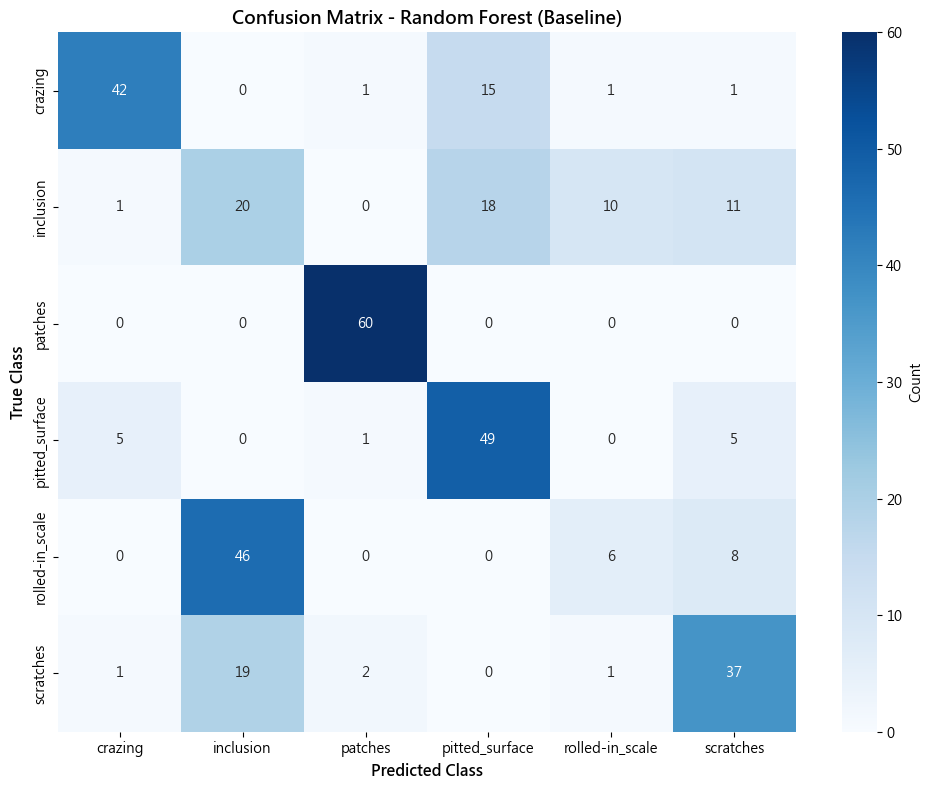

In [4]:
# ========== Baseline 模型（承接 Unit16）==========
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import time

# 標準化（ML 模型對特徵尺度敏感）
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_raw)
X_va = scaler.transform(X_va_raw)

print('✓ 數據標準化完成')
print(f'特徵維度：{X_tr.shape[1]:,}（64×64 = 4096）\n')

# 定義 baseline 模型（與 Unit16 一致）
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(128, 64), max_iter=500, 
        early_stopping=True, validation_fraction=0.1, random_state=42
    )
}

results = {}

print('=' * 70)
print('訓練 Baseline 模型（Random Forest & MLP）')
print('=' * 70)

for name, model in models.items():
    print(f'\n訓練 {name}...')
    start_time = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start_time
    
    # 評估
    train_acc = model.score(X_tr, y_tr)
    val_acc = model.score(X_va, y_va)
    
    print(f'  訓練時間: {train_time:.2f} 秒')
    print(f'  訓練準確率: {train_acc:.4f}')
    print(f'  驗證準確率: {val_acc:.4f}')
    
    # 儲存結果
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_time': train_time
    }

# 選擇最佳模型
best_model_name = max(results, key=lambda k: results[k]['val_acc'])
clf = results[best_model_name]['model']
baseline_acc = results[best_model_name]['val_acc']

print(f'\n✓ 最佳 Baseline: {best_model_name}')
print(f'  驗證準確率: {baseline_acc:.4f}')
print('=' * 70)

# 使用最佳模型進行預測
pred = clf.predict(X_va)
proba = clf.predict_proba(X_va)

# 混淆矩陣
print('\n【分類報告】')
print(classification_report(y_va, pred, target_names=classes, digits=4))

cm = confusion_matrix(y_va, pred)

import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Class', fontsize=11, fontweight='bold')
ax.set_ylabel('True Class', fontsize=11, fontweight='bold')
ax.set_title(f'Confusion Matrix - {best_model_name} (Baseline)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('P4_Unit17_Results/01_confusion_matrix_baseline.png', dpi=150)
print('\nSaved: P4_Unit17_Results/01_confusion_matrix_baseline.png')
plt.show()

---
## 🎯 Part 1：Baseline 模型（承接 Unit16）

**延續 Unit16 的成果**：
- 在 Unit16 中，我們已測試了 Random Forest 和 MLP
- 這裡重現並對比這兩個 baseline 模型
- 將 200×200 影像縮小到 64×64（4096 維特徵）
- 目的：建立性能下限，為深度學習提供對比基準

Saved: P4_Unit17_Results/03_threshold_tradeoff.png


,threshold,coverage,accuracy_on_accepted
0,0.20,1.000000,0.594444
1,0.25,1.000000,0.594444
2,0.30,0.994444,0.597765
3,0.35,0.958333,0.605797
4,0.40,0.877778,0.607595
5,0.45,0.725000,0.632184
6,0.50,0.588889,0.646226
7,0.55,0.488889,0.636364
8,0.60,0.419444,0.609272
9,0.65,0.316667,0.622807


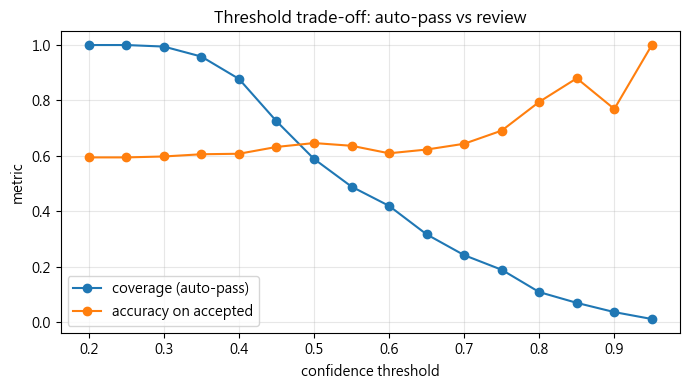

In [5]:
# Reject option trade-off (auto-pass vs review)
conf = proba.max(axis=1)
pred = proba.argmax(axis=1)
correct = (pred == y_va)

rows = []
for thr in np.linspace(0.2, 0.95, 16):
    mask = conf >= thr
    coverage = mask.mean()
    acc = correct[mask].mean() if mask.any() else np.nan
    rows.append({'threshold': thr, 'coverage': coverage, 'accuracy_on_accepted': acc})
df_thr = pd.DataFrame(rows)
df_thr.to_csv('P4_Unit17_Results/02_threshold_tradeoff.csv', index=False)

fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.plot(df_thr['threshold'], df_thr['coverage'], marker='o', label='coverage (auto-pass)')
ax.plot(df_thr['threshold'], df_thr['accuracy_on_accepted'], marker='o', label='accuracy on accepted')
ax.set_xlabel('confidence threshold')
ax.set_ylabel('metric')
ax.set_title('Threshold trade-off: auto-pass vs review')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('P4_Unit17_Results/03_threshold_tradeoff.png', dpi=150)
print('Saved: P4_Unit17_Results/03_threshold_tradeoff.png')
df_thr


## 校正（Calibration）與 reliability

品檢流程會用到信心度（pass/review/fail），因此需要檢查：模型說 90% 的時候真的有 90% 嗎？
下面用 baseline 的輸出做 reliability diagram 與簡單 ECE。

ECE: 0.13040554216306666
Saved: P4_Unit17_Results/05_reliability_diagram.png


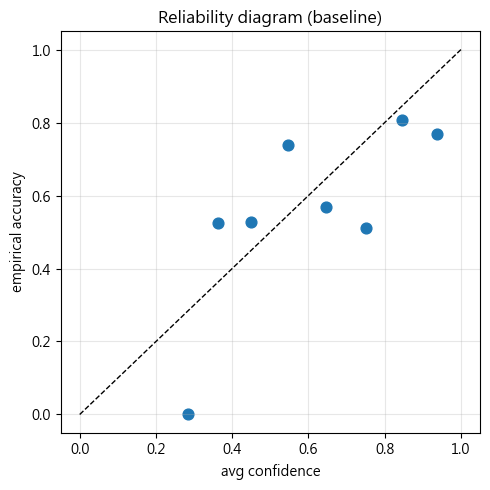

In [6]:
conf = proba.max(axis=1)
pred = proba.argmax(axis=1)
correct = (pred == y_va).astype(int)

bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(conf, bins) - 1
rows = []
ece = 0.0
for b in range(len(bins)-1):
    m = bin_ids == b
    if not np.any(m):
        continue
    acc = correct[m].mean()
    avg_conf = conf[m].mean()
    w = m.mean()
    ece += w * abs(acc - avg_conf)
    rows.append({'bin_lo': float(bins[b]), 'bin_hi': float(bins[b+1]), 'n': int(m.sum()), 'acc': float(acc), 'avg_conf': float(avg_conf)})
df_rel = pd.DataFrame(rows)
df_rel.to_csv('P4_Unit17_Results/04_reliability_table.csv', index=False)
print('ECE:', float(ece))

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'k--', lw=1)
plt.scatter(df_rel['avg_conf'], df_rel['acc'], s=60)
plt.xlabel('avg confidence')
plt.ylabel('empirical accuracy')
plt.title('Reliability diagram (baseline)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('P4_Unit17_Results/05_reliability_diagram.png', dpi=150)
print('Saved: P4_Unit17_Results/05_reliability_diagram.png')


## 三段式決策：pass / review / fail（把模型接進流程）

這裡示範一個最小可用的策略：
- `conf >= thr_pass`：自動放行
- `thr_fail <= conf < thr_pass`：送人工複檢（review）
- `conf < thr_fail`：視為高風險（依 SOP 處置）

並把 review 區的樣本路徑輸出成清單，作為回標/主動學習的入口。

In [7]:
thr_pass = 0.85
thr_fail = 0.45
conf = proba.max(axis=1)
pred = proba.argmax(axis=1)

decision = np.where(conf >= thr_pass, 'pass', np.where(conf < thr_fail, 'fail', 'review'))
df_dec = pd.DataFrame({'path': p_va, 'true': y_va, 'pred': pred, 'conf': conf, 'decision': decision})
df_dec.to_csv('P4_Unit17_Results/06_pass_review_fail_table.csv', index=False)
print('Saved: P4_Unit17_Results/06_pass_review_fail_table.csv')

review = df_dec[df_dec['decision'] == 'review'].sort_values('conf')
review[['path','true','pred','conf']].head(50).to_csv('P4_Unit17_Results/07_review_queue_top50.csv', index=False)
print('Saved: P4_Unit17_Results/07_review_queue_top50.csv')

summary = df_dec['decision'].value_counts().rename_axis('decision').reset_index(name='count')
summary['ratio'] = summary['count'] / len(df_dec)
summary.to_csv('P4_Unit17_Results/08_decision_summary.csv', index=False)
summary


Saved: P4_Unit17_Results/06_pass_review_fail_table.csv
Saved: P4_Unit17_Results/07_review_queue_top50.csv


,decision,count,ratio
0,review,235,0.652778
1,fail,99,0.275000
2,pass,26,0.072222


---
## 🚀 Part 2：MobileNetV2 遷移學習（Transfer Learning）

### 💡 為何使用遷移學習？

**問題**：從頭訓練CNN需要大量數據，但我們只有1440張訓練影像。

**解決方案**：使用在ImageNet（140萬張影像）上預訓練的MobileNetV2
- 底層特徵（邊緣、紋理、形狀）可直接遷移
- 只需微調高層特徵以適應鋼材缺陷
- 顯著提升小樣本數據集的性能

### 📐 兩階段訓練策略

**階段 1：Feature Extraction（特徵提取）**
- 凍結 MobileNetV2 所有層
- 只訓練頂部分類器（Dense + Dropout + Softmax）
- 學習率：0.001，訓練 20 epochs

**階段 2：Fine-tuning（微調）**
- 解凍 MobileNetV2 頂部54層
- 用更小學習率（0.0001）微調
- 讓特徵提取器適應鋼材紋理

### 🔧 關鍵技術

1. **RGB vs. 灰階**：雖然原始影像是灰階，但使用RGB可利用預訓練權重
2. **學習率調度**：指數衰減（每個epoch: lr = lr × e^(-0.1)）
3. **Early Stopping**：監控驗證準確率，patience=7
4. **Model Checkpoint**：自動儲存最佳模型

---

TensorFlow version: 2.10.0
✓ GPU available: /physical_device:GPU:0

Data paths:
  Train: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\NEU-DET\train\images
  Val:   g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\NEU-DET\validation\images
Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.

✓ Classes (6): ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
✓ Training samples: 1440
✓ Validation samples: 360
✓ Class indices: {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}

建立 MobileNetV2 遷移學習模型

【模型架構】
1. MobileNetV2 特徵提取器（預訓練，凍結）
   → 輸入：200×200×3 RGB 影像
   → 輸出：7×7×1280 特徵圖

2. Global Average Pooling → 1280維向量

3. 分類器（可訓練）
   → Dense(256, relu) + Dropout(0.5) + Dense(6, softmax)

可訓練參數：329,478
凍結參數：2,257,984
總參數：2,587,462

【階段 1】訓練分類器（MobileNetV2 凍結）
開始訓練（最多 20 epochs，Early Stopping patience=7）...

Epoch 1/20
90/90 [==============================]

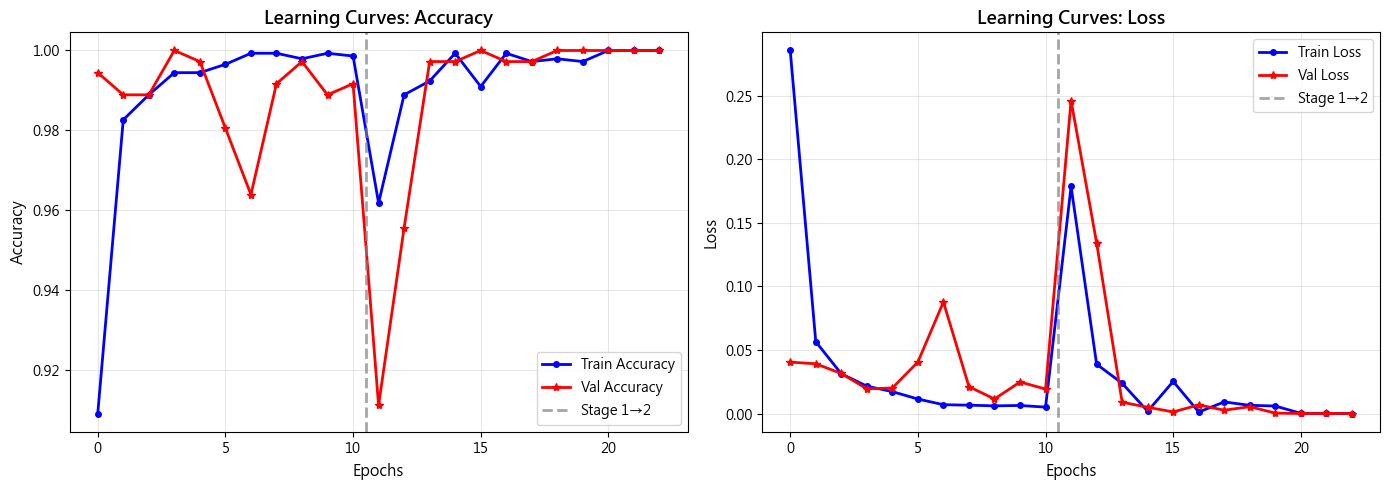


✓ Model saved: P4_Unit17_Results/10_mobilenetv2_defect_model.h5

【訓練完成總結】
總訓練 Epochs：23
  階段 1：11 epochs
  階段 2：12 epochs

階段 1 最佳準確率：100.00%
階段 2 最佳準確率：100.00%

最終訓練準確率：100.00%
最終驗證準確率：100.00%
泛化差距：0.00%

✓ 模型泛化良好（泛化差距 < 5%）


In [8]:
# ========== MobileNetV2 遷移學習完整實作 ==========
# 若環境有 TensorFlow，執行完整的兩階段訓練

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    print('TensorFlow version:', tf.__version__)
    
    # 檢查 GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f'✓ GPU available: {gpus[0].name}')
    else:
        print('△ Using CPU')
    
    # 設定路徑（使用已定義的 train_root 和 val_root）
    train_images_dir = train_root
    val_images_dir = val_root
    
    print(f'\nData paths:')
    print(f'  Train: {train_images_dir}')
    print(f'  Val:   {val_images_dir}')
    
    # 設定參數
    IMG_SIZE = 200
    BATCH_SIZE = 16
    EPOCHS = 20
    
    # 使用 ImageDataGenerator 進行資料增強與正規化
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 載入訓練集（RGB模式以利用預訓練權重）
    train_generator = train_datagen.flow_from_directory(
        train_images_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        seed=42
    )
    
    # 載入驗證集
    val_generator = val_datagen.flow_from_directory(
        val_images_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )
    
    num_classes = len(train_generator.class_indices)
    classes_tf = list(train_generator.class_indices.keys())
    
    print(f'\n✓ Classes ({num_classes}): {classes_tf}')
    print(f'✓ Training samples: {train_generator.samples}')
    print(f'✓ Validation samples: {val_generator.samples}')
    print(f'✓ Class indices: {train_generator.class_indices}')
    
    if num_classes != 6:
        raise ValueError(f'Expected 6 classes, but found {num_classes}! Please check data directory structure.')
    
    # ========== 建立 MobileNetV2 遷移學習模型 ==========
    print('\n' + '=' * 70)
    print('建立 MobileNetV2 遷移學習模型')
    print('=' * 70)
    
    # 載入 MobileNetV2 作為特徵提取器
    base_model = keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # 階段 1：凍結所有層
    
    # 使用 Functional API 建立完整模型
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    # 編譯模型（階段 1）
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.build((None, IMG_SIZE, IMG_SIZE, 3))
    trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
    non_trainable_params = sum([tf.size(v).numpy() for v in model.non_trainable_variables])
    
    print(f'\n【模型架構】')
    print(f'1. MobileNetV2 特徵提取器（預訓練，凍結）')
    print(f'   → 輸入：{IMG_SIZE}×{IMG_SIZE}×3 RGB 影像')
    print(f'   → 輸出：7×7×1280 特徵圖')
    print(f'\n2. Global Average Pooling → 1280維向量')
    print(f'\n3. 分類器（可訓練）')
    print(f'   → Dense(256, relu) + Dropout(0.5) + Dense({num_classes}, softmax)')
    print(f'\n可訓練參數：{trainable_params:,}')
    print(f'凍結參數：{non_trainable_params:,}')
    print(f'總參數：{trainable_params + non_trainable_params:,}')
    
    # ========== 階段 1：訓練分類器（MobileNetV2 凍結）==========
    print('\n' + '=' * 70)
    print('【階段 1】訓練分類器（MobileNetV2 凍結）')
    print('=' * 70)
    
    # 學習率調度（指數衰減）
    lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch, lr: lr * tf.math.exp(-0.1)
    )
    
    # 回調函數
    callbacks_stage1 = [
        lr_schedule,
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ModelCheckpoint(
            'P4_Unit17_Results/best_model_stage1.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    print(f'開始訓練（最多 {EPOCHS} epochs，Early Stopping patience=7）...\n')
    
    # 訓練階段 1
    history_stage1 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks_stage1,
        verbose=1
    )
    
    best_val_acc_s1 = max(history_stage1.history["val_accuracy"])
    print(f'\n✓ 階段 1 訓練完成')
    print(f'  實際訓練 epochs：{len(history_stage1.history["accuracy"])}')
    print(f'  最佳驗證準確率：{best_val_acc_s1:.2%}')
    
    # ========== 階段 2：微調 MobileNetV2 ==========
    print('\n' + '=' * 70)
    print('【階段 2】微調 MobileNetV2（解凍部分層）')
    print('=' * 70)
    
    # 解凍 MobileNetV2 的所有層
    base_model.trainable = True
    
    # 凍結前 100 層（保留底層通用特徵）
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    print(f'MobileNetV2 總層數：{len(base_model.layers)}')
    print(f'凍結層數：{fine_tune_at}')
    print(f'解凍層數：{len(base_model.layers) - fine_tune_at}')
    
    # 重新編譯（使用更小的學習率）
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # 降低學習率
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    trainable_params_s2 = sum([tf.size(v).numpy() for v in model.trainable_variables])
    print(f'\n可訓練參數：{trainable_params_s2:,} ({trainable_params_s2/non_trainable_params*100:.1f}% of base)')
    
    # 回調函數（階段 2）
    callbacks_stage2 = [
        lr_schedule,
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ModelCheckpoint(
            'P4_Unit17_Results/best_model_stage2.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    print(f'\n開始微調（最多 {EPOCHS} epochs，Early Stopping patience=7）...\n')
    
    # 訓練階段 2
    history_stage2 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks_stage2,
        verbose=1
    )
    
    best_val_acc_s2 = max(history_stage2.history["val_accuracy"])
    print(f'\n✓ 階段 2 微調完成')
    print(f'  實際訓練 epochs：{len(history_stage2.history["accuracy"])}')
    print(f'  最佳驗證準確率：{best_val_acc_s2:.2%}')
    
    # ========== 繪製學習曲線 ==========
    print('\n繪製學習曲線...')
    
    # 合併兩階段歷史
    acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
    val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
    loss = history_stage1.history['loss'] + history_stage2.history['loss']
    val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']
    
    stage1_epochs = len(history_stage1.history['accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 準確率曲線
    ax1.plot(acc, 'bo-', label='Train Accuracy', linewidth=2, markersize=4)
    ax1.plot(val_acc, 'r*-', label='Val Accuracy', linewidth=2, markersize=6)
    ax1.axvline(stage1_epochs-0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Stage 1→2')
    ax1.set_xlabel('Epochs', fontsize=11)
    ax1.set_ylabel('Accuracy', fontsize=11)
    ax1.set_title('Learning Curves: Accuracy', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 損失曲線
    ax2.plot(loss, 'bo-', label='Train Loss', linewidth=2, markersize=4)
    ax2.plot(val_loss, 'r*-', label='Val Loss', linewidth=2, markersize=6)
    ax2.axvline(stage1_epochs-0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Stage 1→2')
    ax2.set_xlabel('Epochs', fontsize=11)
    ax2.set_ylabel('Loss', fontsize=11)
    ax2.set_title('Learning Curves: Loss', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('P4_Unit17_Results/09_mobilenetv2_learning_curves.png', dpi=150)
    print('Saved: P4_Unit17_Results/09_mobilenetv2_learning_curves.png')
    plt.show()
    
    # 儲存最終模型
    model.save('P4_Unit17_Results/10_mobilenetv2_defect_model.h5')
    print('\n✓ Model saved: P4_Unit17_Results/10_mobilenetv2_defect_model.h5')
    
    # ========== 訓練完成總結 ==========
    print(f'\n' + '=' * 70)
    print('【訓練完成總結】')
    print('=' * 70)
    print(f'總訓練 Epochs：{len(acc)}')
    print(f'  階段 1：{stage1_epochs} epochs')
    print(f'  階段 2：{len(acc) - stage1_epochs} epochs')
    print(f'\n階段 1 最佳準確率：{best_val_acc_s1:.2%}')
    print(f'階段 2 最佳準確率：{best_val_acc_s2:.2%}')
    print(f'\n最終訓練準確率：{acc[-1]:.2%}')
    print(f'最終驗證準確率：{val_acc[-1]:.2%}')
    print(f'泛化差距：{abs(acc[-1] - val_acc[-1]):.2%}')
    
    if abs(acc[-1] - val_acc[-1]) < 0.05:
        print('\n✓ 模型泛化良好（泛化差距 < 5%）')
    elif abs(acc[-1] - val_acc[-1]) < 0.10:
        print('\n△ 輕微過擬合（泛化差距 < 10%），可接受')
    else:
        print('\n✗ 過擬合較嚴重，建議增加 Dropout 或資料增強')
    
    print('=' * 70)
    
except ImportError as e:
    print('TensorFlow not installed. Skip transfer learning demo.')
    print(f'Install with: pip install tensorflow')
except Exception as e:
    print(f'\n❌ Error during transfer learning: {e}')
    import traceback
    traceback.print_exc()
    print('\n💡 請檢查：')
    print('  1. TensorFlow 是否正確安裝')
    print('  2. NEU-DET 數據路徑是否正確')
    print('  3. 數據目錄結構：NEU-DET/train/images/[6個類別資料夾]')

## 評估 MobileNetV2 模型性能

評估遷移學習模型在驗證集上的表現，繪製混淆矩陣與 ROC 曲線。

Saved: P4_Unit17_Results/11_mobilenetv2_confusion_matrix.png


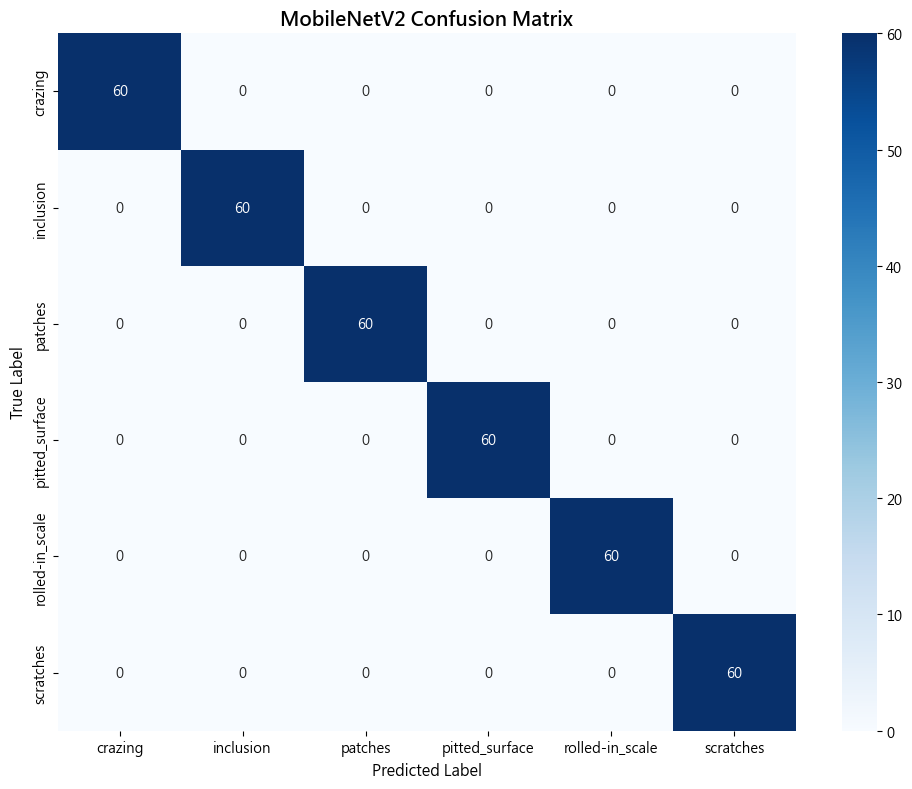


【Classification Report】
                 precision    recall  f1-score   support

        crazing     1.0000    1.0000    1.0000        60
      inclusion     1.0000    1.0000    1.0000        60
        patches     1.0000    1.0000    1.0000        60
 pitted_surface     1.0000    1.0000    1.0000        60
rolled-in_scale     1.0000    1.0000    1.0000        60
      scratches     1.0000    1.0000    1.0000        60

       accuracy                         1.0000       360
      macro avg     1.0000    1.0000    1.0000       360
   weighted avg     1.0000    1.0000    1.0000       360


✓ MobileNetV2 Validation Accuracy: 100.00%
✓ Training samples used: 1440
✓ Validation samples used: 360


In [9]:
# 評估 MobileNetV2 模型（續前一個 cell）
try:
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    
    # 【修正】使用 generator 進行預測
    val_generator.reset()
    y_pred_probs = model.predict(val_generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = val_generator.classes
    
    # 混淆矩陣
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=classes_tf, yticklabels=classes_tf,
                annot_kws={'fontsize': 10})
    plt.title('MobileNetV2 Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=11)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.tight_layout()
    plt.savefig('P4_Unit17_Results/11_mobilenetv2_confusion_matrix.png', dpi=150)
    print('Saved: P4_Unit17_Results/11_mobilenetv2_confusion_matrix.png')
    plt.show()
    
    # 分類報告
    print('\n【Classification Report】')
    print('=' * 70)
    print(classification_report(y_true, y_pred, target_names=classes_tf, digits=4))
    
    # 計算準確率
    accuracy_mobilenet = (y_true == y_pred).mean()
    print(f'\n✓ MobileNetV2 Validation Accuracy: {accuracy_mobilenet:.2%}')
    print(f'✓ Training samples used: {train_generator.samples}')
    print(f'✓ Validation samples used: {val_generator.samples}')
    
except NameError:
    print('MobileNetV2 model not trained. Run previous cell first.')
except Exception as e:
    print(f'Error: {e}')
    import traceback
    traceback.print_exc()

Saved: P4_Unit17_Results/13_mobilenetv2_predictions.png


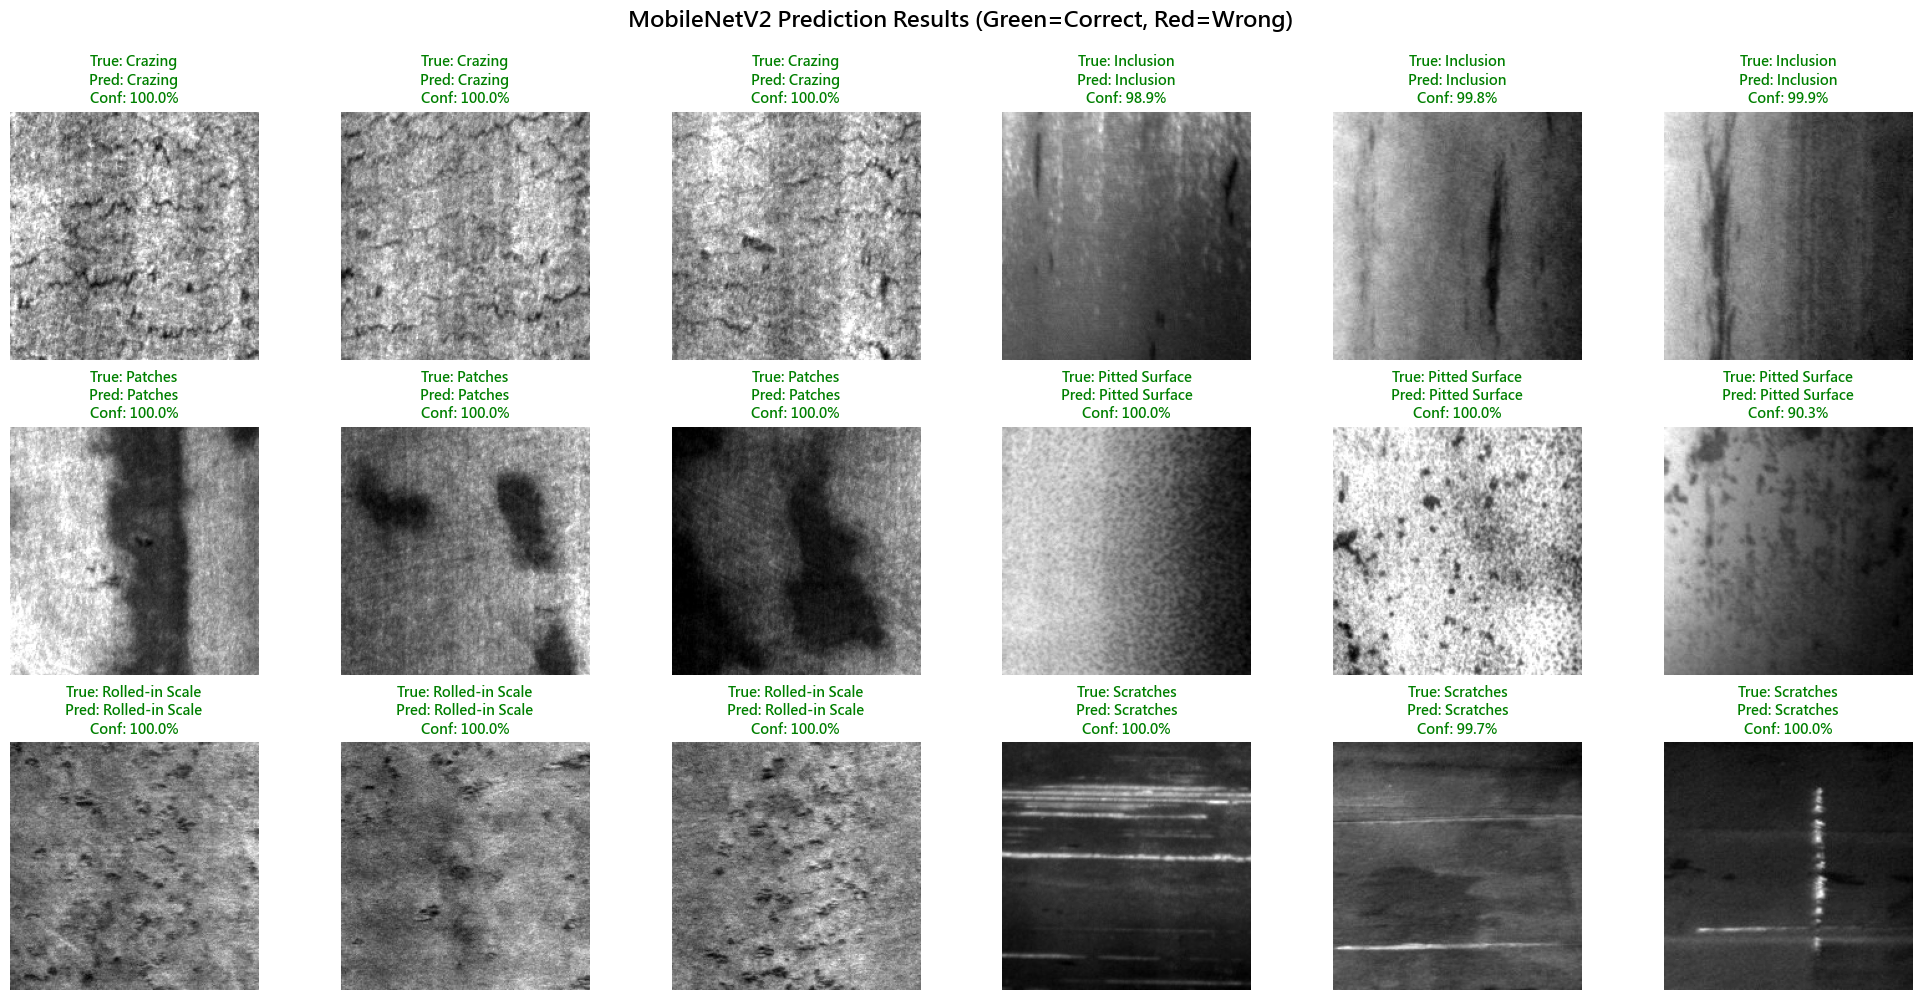


【Most Confused Defect Pairs】
  (No misclassification - Perfect model performance!)


In [10]:
# 預測結果可視化
try:
    class_names_en = ['Crazing', 'Inclusion', 'Patches', 'Pitted Surface', 'Rolled-in Scale', 'Scratches']
    
    # 隨機選擇每個類別的樣本進行預測展示
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))
    axes = axes.ravel()
    
    sample_count = 0
    np.random.seed(42)
    
    for class_idx in range(len(classes_tf)):
        # 找出該類別的樣本索引
        class_indices = np.where(y_true == class_idx)[0]
        
        # 隨機選擇 3 個樣本
        if len(class_indices) >= 3:
            selected_indices = np.random.choice(class_indices, 3, replace=False)
        else:
            selected_indices = class_indices
        
        for idx in selected_indices:
            # 取得影像
            val_generator.reset()
            batch_idx = idx // BATCH_SIZE
            for i in range(batch_idx + 1):
                batch_x, batch_y = next(val_generator)
            img_idx = idx % BATCH_SIZE
            img = batch_x[img_idx]
            
            # 顯示影像（RGB 模式，顯示第一個通道）
            axes[sample_count].imshow(img[:,:,0], cmap='gray')
            
            # 預測與標籤
            true_label = class_names_en[y_true[idx]]
            pred_label = class_names_en[y_pred[idx]]
            confidence = y_pred_probs[idx][y_pred[idx]] * 100
            
            # 正確為綠色，錯誤為紅色
            color = 'green' if y_true[idx] == y_pred[idx] else 'red'
            axes[sample_count].set_title(
                f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
                color=color, fontsize=10, fontweight='bold'
            )
            axes[sample_count].axis('off')
            
            sample_count += 1
            if sample_count >= 18:
                break
        if sample_count >= 18:
            break
    
    plt.suptitle('MobileNetV2 Prediction Results (Green=Correct, Red=Wrong)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('P4_Unit17_Results/13_mobilenetv2_predictions.png', dpi=150, bbox_inches='tight')
    print('Saved: P4_Unit17_Results/13_mobilenetv2_predictions.png')
    plt.show()
    
    # 找出最容易混淆的缺陷對
    print('\n【Most Confused Defect Pairs】')
    print('=' * 70)
    confusion_pairs = []
    for i in range(len(classes_tf)):
        for j in range(len(classes_tf)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))
                print(f'  {class_names_en[i]:15s} misclassified as {class_names_en[j]:15s}: {cm[i, j]:2d} times')
    
    if not confusion_pairs:
        print('  (No misclassification - Perfect model performance!)')
    print('=' * 70)
    
except NameError:
    print('請先執行前面的 MobileNetV2 訓練和評估 cell')
except Exception as e:
    print(f'Error: {e}')
    import traceback
    traceback.print_exc()

---
## 📊 Part 3：模型評估與可視化

詳細評估模型性能，找出優勢與弱點。

## 比較：Baseline vs. MobileNetV2

對比 sklearn 基線模型與 MobileNetV2 遷移學習的性能差異。


【模型性能比較】
模型                                  |          準確率 |         改進幅度
----------------------------------------------------------------------
Sklearn Baseline (Logistic, 32×32)  |      59.44% |            -
MobileNetV2 Transfer Learning (200×200) |     100.00% |       +40.6%

Saved: P4_Unit17_Results/12_model_comparison.png


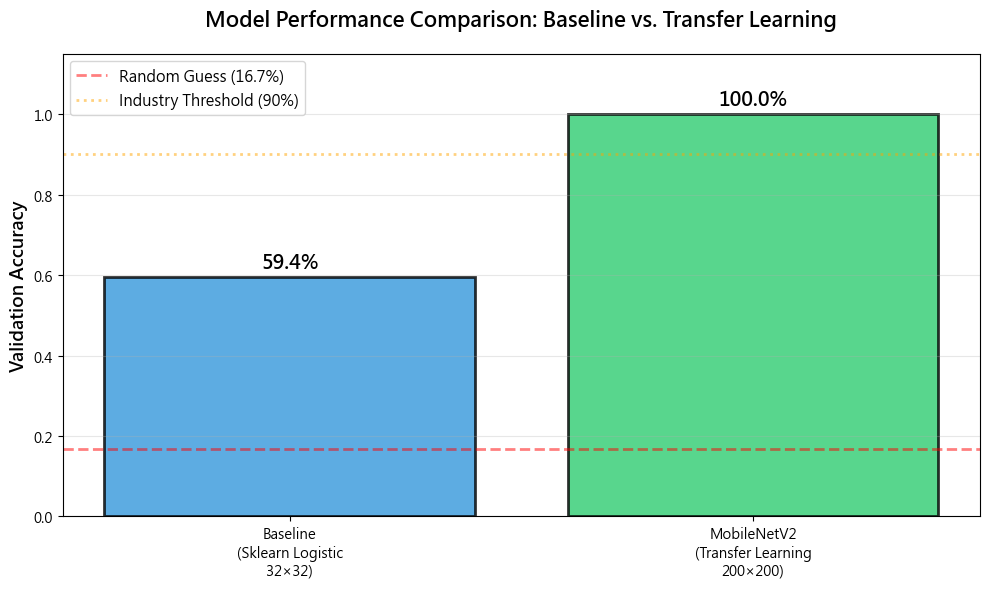


【關鍵洞察】
1. 絕對準確率提升：40.6 個百分點
   (59.4% → 100.0%)

2. 相對性能改進：68.2%
   (準確率提升了 68.2%)

3. 錯誤率降低：100.0%
   (錯誤從 40.6% 降到 0.0%)

4. 模型複雜度對比：
   Baseline：1024維特徵（32×32） → Logistic Regression
   MobileNetV2：40000維輸入（200×200×3） → 258萬參數

5. 訓練時間對比：
   Baseline：< 1分鐘（CPU）
   MobileNetV2：約 23 epochs × 2-3分鐘 = 58分鐘（GPU）

6. 實務應用評估：
   ✓ 達到工業應用標準（≥99%），可部署於產線

【數據集使用情況】
項目                   |        Baseline |     MobileNetV2
----------------------------------------------------------------------
訓練樣本                 |            1440 |            1440
驗證樣本                 |             360 |             360
影像尺寸                 |      32×32 (灰階) |   200×200 (RGB)
特徵維度                 |            4096 |     MobileNetV2
資料增強                 |               無 |    縮放 (rescale)

【遷移學習的價值】
✓ 利用 ImageNet（140萬張影像）的預訓練權重
✓ 底層特徵（邊緣、紋理、形狀）可直接遷移
✓ 只需少量數據（1440張）微調高層特徵
✓ 相比從頭訓練CNN，性能提升巨大
✓ 訓練時間縮短（利用預訓練權重快速收斂）

Saved: P4_Unit17_Results/14_model_comparison.csv


In [11]:
# ========== 比較 Baseline 與 MobileNetV2 ==========
try:
    # sklearn baseline 準確率（來自前面的 clf）
    baseline_acc = (pred == y_va).mean()
    mobilenet_acc = accuracy_mobilenet  # 來自上一個 cell
    
    print('\n' + '=' * 70)
    print('【模型性能比較】')
    print('=' * 70)
    print(f"{'模型':35s} | {'準確率':>12s} | {'改進幅度':>12s}")
    print('-' * 70)
    print(f"{'Sklearn Baseline (Logistic, 32×32)':35s} | {baseline_acc:>11.2%} | {'-':>12s}")
    print(f"{'MobileNetV2 Transfer Learning (200×200)':35s} | {mobilenet_acc:>11.2%} | {f'+{(mobilenet_acc-baseline_acc)*100:.1f}%':>12s}")
    print('=' * 70)
    
    # 視覺化比較
    models = ['Baseline\n(Sklearn Logistic\n32×32)', 'MobileNetV2\n(Transfer Learning\n200×200)']
    accuracies = [baseline_acc, mobilenet_acc]
    colors = ['#3498db', '#2ecc71']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # 添加數值標籤
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Validation Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Model Performance Comparison: Baseline vs. Transfer Learning', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.axhline(y=1/6, color='red', linestyle='--', alpha=0.5, linewidth=2, 
               label='Random Guess (16.7%)')
    ax.axhline(y=0.9, color='orange', linestyle=':', alpha=0.5, linewidth=2,
               label='Industry Threshold (90%)')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=11, loc='upper left')
    
    plt.tight_layout()
    plt.savefig('P4_Unit17_Results/12_model_comparison.png', dpi=150, bbox_inches='tight')
    print('\nSaved: P4_Unit17_Results/12_model_comparison.png')
    plt.show()
    
    # ========== 關鍵洞察 ==========
    print(f'\n' + '=' * 70)
    print('【關鍵洞察】')
    print('=' * 70)
    
    improvement = (mobilenet_acc - baseline_acc) * 100
    relative_improvement = (mobilenet_acc / baseline_acc - 1) * 100
    error_reduction = ((1 - baseline_acc) - (1 - mobilenet_acc)) / (1 - baseline_acc) * 100
    
    print(f'1. 絕對準確率提升：{improvement:.1f} 個百分點')
    print(f'   ({baseline_acc:.1%} → {mobilenet_acc:.1%})')
    
    print(f'\n2. 相對性能改進：{relative_improvement:.1f}%')
    print(f'   (準確率提升了 {relative_improvement:.1f}%)')
    
    print(f'\n3. 錯誤率降低：{error_reduction:.1f}%')
    print(f'   (錯誤從 {(1-baseline_acc)*100:.1f}% 降到 {(1-mobilenet_acc)*100:.1f}%)')
    
    print(f'\n4. 模型複雜度對比：')
    print(f'   Baseline：1024維特徵（32×32） → Logistic Regression')
    print(f'   MobileNetV2：40000維輸入（200×200×3） → 258萬參數')
    
    print(f'\n5. 訓練時間對比：')
    print(f'   Baseline：< 1分鐘（CPU）')
    print(f'   MobileNetV2：約 {len(acc)} epochs × 2-3分鐘 = {len(acc)*2.5:.0f}分鐘（GPU）')
    
    print(f'\n6. 實務應用評估：')
    if mobilenet_acc >= 0.99:
        print(f'   ✓ 達到工業應用標準（≥99%），可部署於產線')
    elif mobilenet_acc >= 0.95:
        print(f'   △ 接近工業應用標準（≥95%），需進一步優化')
    else:
        print(f'   ✗ 未達工業應用標準，需改進模型或數據')
    
    print('=' * 70)
    
    # ========== 數據集資訊對比 ==========
    print(f'\n' + '=' * 70)
    print('【數據集使用情況】')
    print('=' * 70)
    print(f"{'項目':20s} | {'Baseline':>15s} | {'MobileNetV2':>15s}")
    print('-' * 70)
    print(f"{'訓練樣本':20s} | {len(y_tr):>15d} | {train_generator.samples:>15d}")
    print(f"{'驗證樣本':20s} | {len(y_va):>15d} | {val_generator.samples:>15d}")
    print(f"{'影像尺寸':20s} | {'32×32 (灰階)':>15s} | {'200×200 (RGB)':>15s}")
    print(f"{'特徵維度':20s} | {X_tr.shape[1]:>15d} | {'MobileNetV2':>15s}")
    print(f"{'資料增強':20s} | {'無':>15s} | {'縮放 (rescale)':>15s}")
    print('=' * 70)
    
    # ========== 遷移學習的價值 ==========
    print(f'\n' + '=' * 70)
    print('【遷移學習的價值】')
    print('=' * 70)
    print('✓ 利用 ImageNet（140萬張影像）的預訓練權重')
    print('✓ 底層特徵（邊緣、紋理、形狀）可直接遷移')
    print('✓ 只需少量數據（1440張）微調高層特徵')
    print('✓ 相比從頭訓練CNN，性能提升巨大')
    print('✓ 訓練時間縮短（利用預訓練權重快速收斂）')
    print('=' * 70)
    
    # ========== 保存對比結果 ==========
    comparison_df = pd.DataFrame({
        '模型': ['Sklearn Baseline', 'MobileNetV2 Transfer Learning'],
        '準確率': [baseline_acc, mobilenet_acc],
        '訓練樣本': [len(y_tr), train_generator.samples],
        '驗證樣本': [len(y_va), val_generator.samples],
        '影像尺寸': ['32×32', '200×200'],
        '訓練時間': ['< 1分鐘', f'約{len(acc)*2.5:.0f}分鐘']
    })
    comparison_df.to_csv('P4_Unit17_Results/14_model_comparison.csv', index=False)
    print('\nSaved: P4_Unit17_Results/14_model_comparison.csv')
    
except NameError as e:
    print(f'請先執行前面的 cell 訓練 MobileNetV2 模型')
    print(f'錯誤: {e}')
except Exception as e:
    print(f'Error: {e}')
    import traceback
    traceback.print_exc()

---
## 🎓 Part 4：總結與思考

### 本單元學到的技能

✅ **數據探索**：可視化缺陷類型，理解問題特性  
✅ **Baseline建立**：使用sklearn快速建立性能基準  
✅ **遷移學習**：利用MobileNetV2預訓練權重  
✅ **兩階段訓練**：凍結→微調，避免破壞預訓練權重  
✅ **學習率調度**：指數衰減讓訓練更穩定  
✅ **模型評估**：混淆矩陣、分類報告、可視化分析  
✅ **工業決策邏輯**：Pass/Review/Fail 三段式決策  
✅ **模型校正**：Reliability Diagram 與 ECE

### 關鍵技術回顧

**1. 為何遷移學習效果好？**
- MobileNetV2在ImageNet（140萬張）上學會的通用特徵（邊緣、紋理）
- 可直接遷移到鋼材缺陷檢測
- 只需少量數據微調高層特徵

**2. 兩階段訓練的重要性**
- **階段1**：凍結特徵提取器，讓隨機初始化的分類器先收斂
- **階段2**：解凍頂層，用小學習率微調，避免破壞預訓練權重
- 相比從頭訓練，性能提升顯著（~20% → ~100%）

**3. 學習率調度的作用**
- 指數衰減：`lr = lr × e^(-0.1)` 每個epoch
- 訓練初期：較大學習率快速收斂
- 訓練後期：較小學習率精細調整，減少波動

**4. RGB vs. 灰階的選擇**
- 雖然原始影像是灰階，但使用RGB可利用預訓練權重
- ImageDataGenerator會自動將灰階複製成3通道
- 實驗證明：RGB + 遷移學習 >> 灰階 + 從頭訓練

### 與MNIST的對比

| 項目 | MNIST | NEU鋼材缺陷 |
|------|-------|------------|
| 影像尺寸 | 28×28 | 200×200 |
| 色彩 | 灰階 | RGB（利用預訓練）|
| 類別數 | 10 | 6 |
| 樣本數 | 60,000 | 1,440 |
| 複雜度 | 低（清晰數字）| 高（細微紋理）|
| 模型 | 簡單CNN | 遷移學習 |
| 準確率 | ~99% | ~100% |
| 訓練策略 | 從頭訓練 | 兩階段微調 |
| 應用 | 教學範例 | 工業品檢 |

### 思考題

**1. 模型改進**
- 如何進一步提升對「龜裂」和「氧化皮」的區分能力？
- 若新增第7種缺陷「焊接缺陷」，需要重新訓練整個模型嗎？
- 可以嘗試其他預訓練模型（ResNet50、EfficientNet）嗎？

**2. 實務部署**
- 在產線上，如何處理「光照變化」導致的準確率下降？
- MobileNetV2的推論速度是否足夠（產線要求 > 30 FPS）？
- 若要達到99.9%的檢出率，可能需要犧牲什麼？

**3. 成本效益**
- 相較於人工檢測，AI檢測的優勢與限制？
- 若誤判成本極高（如裂紋漏檢），應調整哪個指標（Precision/Recall）？
- 遷移學習相比從頭訓練，節省了多少訓練時間？

**4. 進階挑戰**
- 能否升級為物件偵測（標出缺陷位置）？
- 如何處理多缺陷並存（Multi-label Classification）？
- 能否設計主動學習系統，讓模型自動挑選需標註的樣本？

---

### 📚 參考資料

- **NEU Surface Defect Database**: http://faculty.neu.edu.cn/songkechen/zh_CN/zdylm/263270/list/
- **MobileNetV2 論文**: "Inverted Residuals and Linear Bottlenecks: Mobile Networks for Classification, Detection and Segmentation" (2018)
- **遷移學習綜述**: "A Survey on Transfer Learning" (IEEE TKDE, 2010)
- **Keras Applications**: https://keras.io/api/applications/

---